Lunar Lander sin LR decay

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Episode:     1		score: -103.46		average: -103.46
Episode:     2		score:  -87.44		average:  -95.45
Episode:     3		score: -327.91		average: -172.94
Episode:     4		score: -113.18		average: -158.00
Episode:     5		score:  -23.36		average: -131.07
Episode:     6		score: -431.78		average: -181.19
Episode:     7		score:  -80.99		average: -166.87
Episode:     8		score: -103.32		average: -158.93
Episode:     9		score: -176.88		average: -160.92
Episode:    10		score: -206.77		average: -165.51
Episode:    11		score: -189.44		average: -167.68
Episode:    12		score: -158.80		average: -166.94
Episode:    13		score: -301.53		average: -177.30
Episode:    14		score:  -81.82		average: -170.48
Episode:    15		score:  -63.68		average: -163.36
Episode:    16		score: -195.25		average: -165.35
Episode:    17		score: -129.28		average: -163.23
Episode:    18		score: -123.83		average: -161.04
Episode:    19		score: -121.68		avera

Episode:   161		score: -210.75		average:  -76.42
Episode:   162		score:   21.67		average:  -75.38
Episode:   163		score:    8.87		average:  -74.19
Episode:   164		score:  -43.40		average:  -73.95
Episode:   165		score:   81.61		average:  -70.32
Episode:   166		score:    8.70		average:  -69.55
Episode:   167		score:   35.30		average:  -68.41
Episode:   168		score:   95.66		average:  -65.30
Episode:   169		score:   95.20		average:  -63.33
Episode:   170		score:   66.17		average:  -61.58
Episode:   171		score:  -10.68		average:  -60.83
Episode:   172		score:   14.81		average:  -60.39
Episode:   173		score:  -31.82		average:  -59.66
Episode:   174		score:    5.24		average:  -58.95
Episode:   175		score:    7.11		average:  -58.07
Episode:   176		score:   97.71		average:  -56.35
Episode:   177		score:  -25.16		average:  -55.75
Episode:   178		score:  110.47		average:  -54.22
Episode:   179		score:   73.20		average:  -52.54
Episode:   180		score:  102.93		average:  -50.02
Episode:   181		scor

Episode:   329		score:  290.27		average:  162.70
Episode:   330		score:  232.66		average:  165.64
Episode:   331		score:  274.55		average:  165.57
Episode:   332		score:  267.65		average:  166.24
Episode:   333		score:  238.96		average:  165.85
Episode:   334		score:  271.44		average:  167.06
Episode:   335		score:  264.76		average:  167.03
Episode:   336		score:  127.69		average:  165.99
Episode:   337		score:    7.48		average:  166.13
Episode:   338		score:  -36.01		average:  163.12
Episode:   339		score:  266.75		average:  163.29
Episode:   340		score:  181.56		average:  163.01
Episode:   341		score:  260.88		average:  162.76
Episode:   342		score:   15.49		average:  160.68
Episode:   343		score:  259.49		average:  160.73
Episode:   344		score:  282.49		average:  161.13
Episode:   345		score:  233.30		average:  161.79
Episode:   346		score:  272.18		average:  162.35
Episode:   347		score:   44.30		average:  159.72
Episode:   348		score:  270.41		average:  159.62
Episode:   349		scor

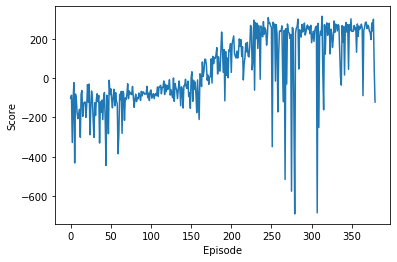

In [1]:
import os

import random
import gym
import pylab
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

#tf.config.experimental_run_functions_eagerly(True)
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import copy

EPISODES = 10000 # Number of times the enviroment is ran
LOSS_CLIPPING = 0.2 # Approximated values stated in the original paper
ENTROPY_LOSS = 0.001 # Epochs to train the network (recommended between 3 and 30)
LR = 0.0003 # Learning rate 
NUM_ACTIONS = 4 # Number of possible action in the environment
NUM_STATES = 8 # Number of possible states in the exvironment
EPOCHS = 10 # Epochs to train the network (recommended between 3 and 30)
BATCH_SIZE = 64 # Batch size for the neural nets
BUFFER_SIZE = 2048 # Buffer of experiences
SHUFFLE = True # Whether to shuffle data or not while training
OPTIMIZER = Adam # Optimizer for both actor and critic
GAMMA = 0.99 # Used for the estimated reward
LAMBDA = 0.95 # Used in the original paper un the GAE
NORMALIZE = True # Whether to normalize GAE or not



# Create the actor used to select the action given an state
class Actor_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(128, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(128, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(128, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        
        # Softmax as there are different probabilities depending on the action
        output = Dense(NUM_ACTIONS, activation="softmax")(X)
        
        # Compile the model with the custom loss
        self.model = Model(inputs = X_input, outputs = output)
        self.model.compile(loss=self.ppo_loss, optimizer=OPTIMIZER(lr=LR))

    # Custom loss functions for the PPO
    def ppo_loss(self, y_true, y_pred):
        # Unpack the elements given in the true label
        advantages, true_label, actions = y_true[:, :1], y_true[:, 1:1+NUM_ACTIONS], y_true[:, 1+NUM_ACTIONS:]
        
        prob = actions * y_pred
        old_prob = actions * true_label 

        ratio = K.exp(K.log(prob + 1e-10) - K.log(old_prob + 1e-10))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

# Create the critic which will criticise how the actor is performing    
class Critic_Model:
    def __init__(self):
        X_input = Input(NUM_STATES)

        X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X_input)
        X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X)
        X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X)
        
        # Linear output to know how good the action is
        value = Dense(1)(X)
        
        # Compile it with mse loss and gradient descent
        self.model = Model(inputs=X_input, outputs = value)
        self.model.compile(loss='mse', optimizer=OPTIMIZER(lr=LR))

# Combine both Actor and Critic to create the agent
class PPOAgent:
    def __init__(self, env_name):
        # Environment parameters
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.episode = 0 # used to track current number episoded since start
        self.max_average = 0 # record max average reached
        
        # Used to plot a grapgh of the train process
        self.scores_, self.average_ = [], []

        # Create Actor-Critic network models
        self.Actor = Actor_Model()
        self.Critic = Critic_Model()
    
        # Names for the models
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"

    # Get the action given the current state    
    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.model.predict(state)[0]
        
        # Probability based to choose the action
        action = np.random.choice(NUM_ACTIONS, p=prediction)
        action_onehot = np.zeros([NUM_ACTIONS])
        action_onehot[action] = 1
        return action, action_onehot, prediction

    # Generalized Advantage Estimation implemented in the original paper
    def get_gaes(self, rewards, dones, values, next_values):
        # Dones are used to track when is the final step of an episode, so next values are no applied
        deltas = [r + GAMMA * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * GAMMA * LAMBDA * gaes[t + 1]

        target = gaes + values
        if NORMALIZE:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # Reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions for state and next state
        values = self.Critic.model.predict(states)
        next_values = self.Critic.model.predict(next_states)

        # Get the advantage
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))

        # Stack info to unpack it in the custom loss
        y_true = np.hstack([advantages, predictions, actions])

        # Training Actor and Critic networks
        a_loss = self.Actor.model.fit(states, y_true, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)
        c_loss = self.Critic.model.fit(states, target, epochs=EPOCHS, verbose=0, shuffle=SHUFFLE, batch_size=BATCH_SIZE)

 
    def load(self):
        self.Actor.Actor.load_weights(self.Actor_name)
        self.Critic.Critic.load_weights(self.Critic_name)

    def save(self):
        self.Actor.model.save_weights(self.Actor_name)
        self.Critic.model.save_weights(self.Critic_name)

    def run_batch(self): # train every self.Training_batch episodes
        global LR
        state = self.env.reset()
        state = np.reshape(state, [1, NUM_STATES])
        done, score = False, 0
        finished = False
        while finished == False:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, predictions, dones = [], [], [], [], [], []
            for t in range(BUFFER_SIZE):
                #self.env.render()
                # Actor picks an action
                action, action_onehot, prediction = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, NUM_STATES]))
                actions.append(action_onehot)
                rewards.append(reward)
                dones.append(done)
                predictions.append(prediction)
                # Update current state
                state = np.reshape(next_state, [1, NUM_STATES])
                score += reward
                if done:
                    self.episode += 1
                    self.scores_.append(score)
                    #average, SAVING = self.PlotModel(score, self.episode)
                    #print("episode: {}/{}, score: {}, average: {:.2f} {}".format(self.episode, EPISODES, score, average, SAVING))
                    if self.episode >= 100:
                        average = sum(self.scores_[-100:])/100
                        print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, score, average))
                        if average > self.max_average:
                            self.max_average = average
                            if self.max_average > 150:
                                self.save()
                            #LR *= 0.95
                            #K.set_value(self.Actor.model.optimizer.learning_rate, LR)
                            #K.set_value(self.Critic.model.optimizer.learning_rate, LR)
                            
                        if average > 200:
                            plt.plot(self.scores_)
                            plt.xlabel("Episode")
                            plt.ylabel("Score")
                            finished = True
                            break

                    else:
                        print('Episode: {:>5}\t\tscore: {:>7.2f}\t\taverage: {:>7.2f}'.format(self.episode, score, sum(self.scores_)/len(self.scores_)))
                    
                    
                    state, done, score = self.env.reset(), False, 0
                    state = np.reshape(state, [1, NUM_STATES])
                    
            self.replay(states, actions, rewards, predictions, dones, next_states)
            if self.episode >= EPISODES:
                break
        self.env.close()  
                    
if __name__ == "__main__":
    start = time.time()
    env_name = 'LunarLander-v2'
    agent = PPOAgent(env_name)
    #agent.run() # train as PPO, train every epesode
    agent.run_batch() # train as PPO, train every batch, trains better
    #agent.run_multiprocesses(num_worker = 8)  # train PPO multiprocessed (fastest)
    #agent.test()
    print((time.time() - start)/60)